In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set_style('darkgrid')

In [3]:
spotipy_client_id = os.environ.get('SPOTIPY_CLIENT_ID')
spotipy_secret = os.environ.get('SPOTIPY_CLIENT_SECRET')
spotipy_redirect_uri = os.environ.get('SPOTIPY_REDIRECT_URI')

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = spotipy_client_id, 
                                                                              client_secret = spotipy_secret))

## Extracting my top 100 most played songs of 2022.

In [4]:

playlist_uri = 'spotify:playlist:4VoHaGEmHOqKDV3jJiJGLL'
track_uris = [x['track']['uri'] for x in spotify.playlist_tracks(playlist_uri)['items']]

In [5]:
spotify_data = {'track_uri': [], 'track_name': [], 'artist_name': [], 'artist_genres': [], 'album_name': []}

def exclude_keys(dictionary, keys):
    return {
        key:value for key, value in dictionary.items() if key not in keys
    }

for track in spotify.playlist_tracks(playlist_uri)['items']:
    track_uri = track['track']['uri']
    if track_uri not in spotify_data['track_uri']:
        spotify_data['track_uri'].append(track_uri)
    
        track_name = track['track']['name']
        spotify_data['track_name'].append(track_name)
    
        artist_uri = track['track']['artists'][0]['uri']
        artist_info = spotify.artist(artist_uri)
        artist_genres = artist_info['genres']
    
        spotify_data['artist_name'].append(track['track']['artists'][0]['name'])
        spotify_data['artist_genres'].append(artist_genres)
    
        spotify_data['album_name'].append(track['track']['album']['name'])
        
        for key in exclude_keys(spotify.audio_features(track_uri)[0], ['id', 'uri', 'track_href', 'analysis_url', 'type']).keys():
            if key not in spotify_data.keys():
                spotify_data[key] = []
                spotify_data[key].append(spotify.audio_features(track_uri)[0][key])
            else:
                spotify_data[key].append(spotify.audio_features(track_uri)[0][key])
    

In [9]:
spotify_df = pd.DataFrame(spotify_data)
spotify_df.head()

,track_uri,track_name,artist_name,artist_genres,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:1zxfRSZcaonV1VXcY0PgY5,High School in Jakarta,NIKI,"[indonesian r&b, pop]",Nicole,0.873,0.488,7,-8.285,0,0.0413,0.531,0.000132,0.153,0.462,119.983,219040,4
1,spotify:track:0F02KChKwbcQ3tk4q1YxLH,晴天,Jay Chou,"[c-pop, mandopop, taiwan pop, zhongguo feng]",葉惠美,0.547,0.567,7,-7.295,1,0.0242,0.276,0.000548,0.104,0.399,137.130,269747,4
2,spotify:track:6xGruZOHLs39ZbVccQTuPZ,Glimpse of Us,Joji,[viral pop],Glimpse of Us,0.440,0.317,8,-9.258,1,0.0531,0.891,0.000005,0.141,0.268,169.914,233456,3
3,spotify:track:4LRPiXqCikLlN15c3yImP7,As It Was,Harry Styles,[pop],As It Was,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.662,173.930,167303,4
4,spotify:track:78TbTvePaJ6FFdwSMSXARy,勁浪漫 超溫馨,Gareth.T,"[chill r&b, hk-pop, hong kong hip hop]",勁浪漫 超溫馨,0.628,0.315,1,-8.317,1,0.0331,0.649,0.000000,0.095,0.731,134.973,199548,3


#### https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features
Acousticness:
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

Danceability:
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

duration_ms:
The duration of the track in milliseconds.

Energy:
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


Instrumentalness:
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

Key:
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.


Liveness:
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

Loudness:
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

Mode:
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

Speechiness:
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

Tempo:
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

Time signature:
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

Valence:
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [11]:
num_cols = list(spotify_df.columns[5:])
print(num_cols)

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


13

In [7]:
spotify_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,0.587450,0.576410,4.710000,-6.683170,0.870000,0.048208,0.343870,0.010372,0.171099,0.416685,125.003350,225621.500000,3.85000
std,0.122463,0.161509,3.409123,2.061461,0.337998,0.037686,0.289858,0.051265,0.116398,0.221534,28.882193,57650.960584,0.35887
min,0.204000,0.196000,0.000000,-14.286000,0.000000,0.023200,0.000417,0.000000,0.042400,0.067300,74.969000,141093.000000,3.00000
25%,0.518000,0.457750,2.000000,-7.754250,1.000000,0.031050,0.045975,0.000000,0.097425,0.236250,99.231250,193240.000000,4.00000
50%,0.598000,0.576000,5.000000,-6.547500,1.000000,0.036600,0.291500,0.000000,0.120000,0.395000,122.015500,221412.500000,4.00000
75%,0.680000,0.708500,7.000000,-5.359000,1.000000,0.049850,0.567000,0.000116,0.204250,0.527500,145.901000,250264.000000,4.00000
max,0.873000,0.875000,11.000000,-2.724000,1.000000,0.308000,0.914000,0.449000,0.764000,0.956000,184.008000,613027.000000,4.00000


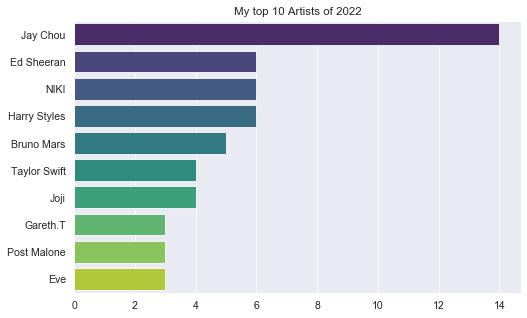

In [160]:
fig , axes = plt.subplots(1,1,figsize=(8,5))
artist_counts = spotify_df.artist_name.value_counts()
sns.barplot(x = artist_counts[:10].values, y = artist_counts[:10].index, ax = axes, palette = "viridis")
plt.title('My top 10 Artists of 2022');

### Looks like the artist that I listened to most in 2022 was Jay Chou.

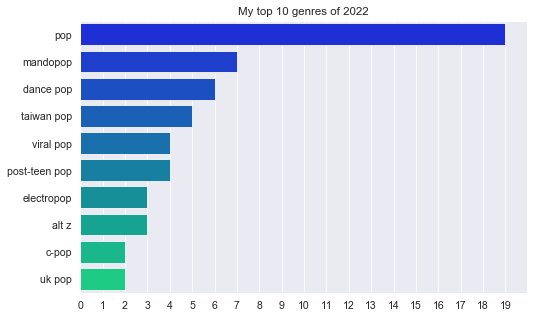

In [165]:
genre_counts = spotify_df.artist_genres.value_counts()
genre_dict = {}
for genres in genre_counts.index:
    if len(genres) == 1: # only one genre
        if genres[0] not in genre_dict.keys():
            genre_dict[genres[0]] = 1
            
        else: #genres already in dictionary
            genre_dict[genres[0]] = genre_dict[genres[0]] + 1
            
    else: # multiple genres
        for genre in genres:
            if genre not in genre_dict.keys():
                genre_dict[genre] = 1
                
            else:
                genre_dict[genre] = genre_dict[genre] + 1
                
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse = True))
top10_genre = list(genre_dict.keys())[:10]
top10_genre_count = list(genre_dict.values())[:10]

fig , axes = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x = top10_genre_count, y = top10_genre, ax = axes, palette = "winter")
plt.title("My top 10 genres of 2022");
plt.xticks(range(0, 20));

### The genres that I listened to most in 2022 were pop, mandopop and dance pop.

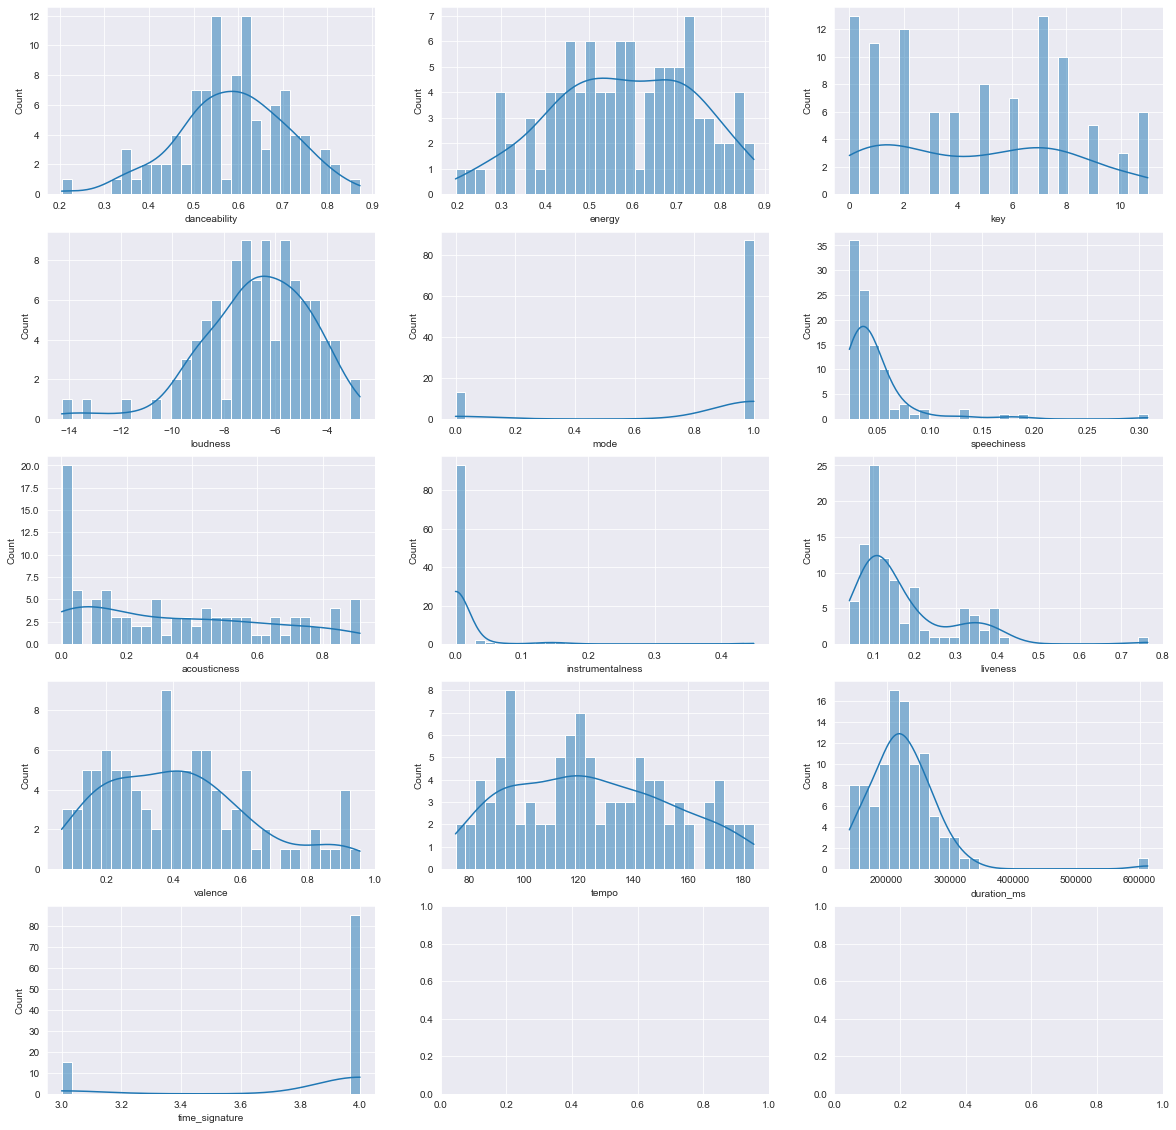

In [21]:
fig, axes = plt.subplots(5,3, figsize = (20, 20))
axes_no = 0
axes = axes.flatten()
for col in num_cols:
    sns.histplot(data = spotify_df, x = col, kde = True, bins = 30, ax = axes[axes_no])
    axes_no += 1

In [32]:
spotify_df[['instrumentalness', 'tempo', 'time_signature', 'mode', 'key']]
# Time signature, mode and key are categorical. OHE to be applied.

,instrumentalness,tempo,time_signature,mode,key
0,0.000132,119.983,4,0,7
1,0.000548,137.130,4,1,7
2,0.000005,169.914,3,1,8
3,0.001010,173.930,4,0,6
4,0.000000,134.973,3,1,1
...,...,...,...,...,...
95,0.000000,157.916,4,1,0
96,0.000000,130.470,4,1,2
97,0.000000,74.969,4,1,3
98,0.000000,116.959,3,1,1


#### Scaling continuous variables

In [48]:
spotify_df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_genres', 'album_name',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [47]:
num_cols = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']

spotify_df[num_cols] = MinMaxScaler().fit_transform(spotify_df[num_cols])
spotify_df.head()

,track_uri,track_name,artist_name,artist_genres,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:1zxfRSZcaonV1VXcY0PgY5,High School in Jakarta,NIKI,"[indonesian r&b, pop]",Nicole,1.000000,0.430044,7,0.519028,0,0.063553,0.580772,0.000294,0.153271,0.444132,0.412825,0.165165,4
1,spotify:track:0F02KChKwbcQ3tk4q1YxLH,晴天,Jay Chou,"[c-pop, mandopop, taiwan pop, zhongguo feng]",葉惠美,0.512706,0.546392,7,0.604653,1,0.003511,0.301651,0.001220,0.085366,0.373242,0.570080,0.272610,4
2,spotify:track:6xGruZOHLs39ZbVccQTuPZ,Glimpse of Us,Joji,[viral pop],Glimpse of Us,0.352765,0.178203,8,0.434873,1,0.104986,0.974824,0.000011,0.136641,0.225835,0.870743,0.195712,3
3,spotify:track:4LRPiXqCikLlN15c3yImP7,As It Was,Harry Styles,[pop],As It Was,0.472347,0.787923,6,0.773915,0,0.114115,0.373894,0.002249,0.372228,0.669180,0.907574,0.055537,4
4,spotify:track:78TbTvePaJ6FFdwSMSXARy,勁浪漫 超溫馨,Gareth.T,"[chill r&b, hk-pop, hong kong hip hop]",勁浪漫 超溫馨,0.633782,0.175258,1,0.516260,1,0.034761,0.709933,0.000000,0.072894,0.746821,0.550299,0.123863,3


#### Converting numerical columns into a single vector representing all songs

In [77]:
to_vect_cols = list(spotify_df.columns)[5:]
to_vect_df = spotify_df[to_vect_cols]
top_songs_array = to_vect_df.to_numpy()
mean_vector = np.mean(top_songs_array, axis = 0)

## Generating recommendations from Today's Top Hits

In [72]:
today_top_hits = "spotify:playlist:37i9dQZF1DXcBWIGoYBM5M"
top_hits_data = {'track_uri': [], 'track_name': [], 'artist_name': [], 'artist_genres': [], 'album_name': []}

for track in spotify.playlist_tracks(today_top_hits)['items']:
    track_uri = track['track']['uri']
    if track_uri not in spotify_df['track_uri']:
        top_hits_data['track_uri'].append(track_uri)
    
        track_name = track['track']['name']
        top_hits_data['track_name'].append(track_name)
    
        artist_uri = track['track']['artists'][0]['uri']
        artist_info = spotify.artist(artist_uri)
        artist_genres = artist_info['genres']
    
        top_hits_data['artist_name'].append(track['track']['artists'][0]['name'])
        top_hits_data['artist_genres'].append(artist_genres)
    
        top_hits_data['album_name'].append(track['track']['album']['name'])
        
        for key in exclude_keys(spotify.audio_features(track_uri)[0], ['id', 'uri', 'track_href', 'analysis_url', 'type']).keys():
            if key not in top_hits_data.keys():
                top_hits_data[key] = []
                top_hits_data[key].append(spotify.audio_features(track_uri)[0][key])
            else:
                top_hits_data[key].append(spotify.audio_features(track_uri)[0][key])

In [74]:
top_hits_df = pd.DataFrame(top_hits_data)
top_hits_df[num_cols] = MinMaxScaler().fit_transform(top_hits_df[num_cols])
top_hits_df.head()

,track_uri,track_name,artist_name,artist_genres,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,SZA,"[pop, r&b]",SOS,0.561528,0.702458,8,0.739277,1,0.038311,0.057744,0.214925,0.271152,0.434459,0.075108,0.202422,4
1,spotify:track:0V3wPSX9ygBnCm8psDIegu,Anti-Hero,Taylor Swift,[pop],Midnights,0.551627,0.583441,4,0.669841,1,0.074105,0.144415,0.000003,0.222732,0.566113,0.156284,0.517228,4
2,spotify:track:3nqQXoyQOWXiESFLlDF1hG,Unholy (feat. Kim Petras),Sam Smith,"[dance pop, pop, uk pop]",Unholy (feat. Kim Petras),0.660537,0.362225,2,0.602090,1,0.170582,0.014241,0.000007,0.538736,0.228392,0.501218,0.222599,4
3,spotify:track:2dHHgzDwk4BJdRwy9uXhTO,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,[rap],HEROES & VILLAINS,0.661952,0.553687,1,0.717536,0,0.064318,0.463729,0.000000,0.070336,0.152833,0.165809,0.657514,4
4,spotify:track:0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),Rema,[nigerian pop],Calm Down (with Selena Gomez),0.783593,0.794308,11,0.784866,1,0.035515,0.424789,0.000999,0.151376,0.874070,0.257308,0.777380,4


#### Generating cosine similarity for each song

In [81]:
top_hits_df['cos_similarity'] = cosine_similarity(top_hits_df[to_vect_cols], mean_vector.reshape(1, -1))[:, 0]

In [86]:
top_10_rec = top_hits_df.sort_values('cos_similarity', ascending = False).head(10)
top_10_rec

,track_uri,track_name,artist_name,artist_genres,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cos_similarity
13,spotify:track:0O6u0VJ46W86TxN9wgyqDj,I Like You (A Happier Song) (with Doja Cat),Post Malone,"[dfw rap, melodic rap, rap]",Twelve Carat Toothache,0.687412,0.618370,5,0.717199,1,0.138982,0.134401,0.000000,0.169215,0.496279,0.196285,0.464366,4,0.997075
38,spotify:track:3NanY0K4okhIQzL33U5Ad8,Boy's a liar,PinkPantheress,[],Boy's a liar,0.578501,0.835705,5,0.515126,1,0.043624,0.277926,0.004194,0.388379,0.803091,0.520026,0.049582,4,0.996257
1,spotify:track:0V3wPSX9ygBnCm8psDIegu,Anti-Hero,Taylor Swift,[pop],Midnights,0.551627,0.583441,4,0.669841,1,0.074105,0.144415,0.000003,0.222732,0.566113,0.156284,0.517228,4,0.990658
16,spotify:track:1DzJbVkBELu6jDu6q0T0tk,Nothing Is Lost (You Give Me Strength),The Weeknd,"[canadian contemporary r&b, canadian pop, pop]",Avatar: The Way of Water (Original Motion Pict...,0.386139,0.648124,5,0.574366,1,0.021532,0.000000,0.000033,0.171764,0.093303,0.459397,0.967215,4,0.989206
25,spotify:track:78Sw5GDo6AlGwTwanjXbGh,Here With Me,d4vd,[bedroom pop],Here With Me,0.462518,0.358344,4,0.531811,1,0.000000,0.593903,0.000137,0.187054,0.285633,0.510339,0.798710,4,0.987417
29,spotify:track:0HqZX76SFLDz2aW8aiqi7G,Bones,Imagine Dragons,"[modern rock, rock]",Bones,0.743989,0.711514,5,0.913626,0,0.057606,0.022697,0.000000,0.053007,0.609616,0.328817,0.278647,4,0.986734
10,spotify:track:5odlY52u43F5BjByhxg7wg,golden hour,JVKE,[modern indie pop],this is what ____ feels like (Vol. 1-4),0.379066,0.518758,4,0.818994,1,0.019016,0.726302,0.241791,0.497961,0.131082,0.130590,0.574945,3,0.985060
7,spotify:track:1xzi1Jcr7mEi9K2RfzLOqS,CUFF IT,Beyoncé,"[dance pop, pop, r&b]",RENAISSANCE,0.753890,0.642950,7,0.745934,1,0.323266,0.040721,0.000014,0.038736,0.690899,0.338635,0.683571,4,0.982380
19,spotify:track:73vIOb4Q7YN6HeJTbscRx5,Miss You,Oliver Tree,[alternative hip hop],Miss You,0.480905,0.711514,6,0.664026,0,0.076902,0.014019,0.001597,0.232926,0.183744,0.641627,0.552990,4,0.981762
6,spotify:track:4LRPiXqCikLlN15c3yImP7,As It Was,Harry Styles,[pop],As It Was,0.386139,0.697283,6,0.773742,0,0.084732,0.380285,0.001507,0.653415,0.713795,0.934083,0.292372,4,0.981359
